In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization # model creation hyperparamters for cnn needed
import matplotlib.pyplot as plt
import tensorflow_probability as tfp # tensorflow probability for Mixup augmentation
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError # for performance measurement
import tensorflow_datasets as tfds
import albumentations as A
from google.colab import drive # import drive to save the project so that we dont need to start from beginning

# <h1><b>Data Preparation</b></h1>

---



<h3>Data Loading</h3>

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split=['train']) # download dataset from tensorflow builtin datasets

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteEQWF39/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
    print(list(train_dataset.take(1).as_numpy_iterator())) # gives you an idea whats in the dataset and lets you visualize data better


    val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_dataset.take(int(VAL_RATIO*DATASET_SIZE))
    print(list(val_dataset.take(1).as_numpy_iterator()))

    test_dataset = dataset.skip(int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)))
    print(list(test_dataset.take(1).as_numpy_iterator()))
    return train_dataset, val_dataset, test_dataset

In [25]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# dataset = tf.data.Dataset.range(10)
# This is just for testing and picturing purposes
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
# print(train_dataset, val_dataset, test_dataset)

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [ ]:
for data in dataset[0].take(4):
  print(data)

In [ ]:
dataset_info

# <h1><b>Dataset Visualization</b></h1>

---



In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1) # 4 by 4 rows and columns
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  ax.axis('off')


In [ ]:
dataset_info.features['label'].int2str(0)

'parasitized'

In [ ]:
dataset_info.features['label'].int2str(1)

'uninfected'

<h1><b>Data Preprocessing</b></h1>

---



<p>No we just resize our pictures irrespective of their height and width to a one size for all</p>
<p>Then we do Normalization of values to bring down the values to machine learning size, do this when there is no mean and no std</p>
<p>Previously we did standardization because the valeus fell under a bell curve and had mean and std</p>

In [7]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/ 255.0, label

#  no need anymore becasue already declared in model


## Resize-Rescale layers using Sequential API

In [ ]:
# using keras
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(IM_SIZE, IM_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255)
])

## Data Augmentation using tf image

In [ ]:
def augment(image, label):

  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  # image = tf.image.adjust_saturation(image, saturation_factor = 0.3) in this case there is no benefits as saturation can lead to parasitized cell to become uninfected
  # so be careful choosing what you want to augment
  image = tf.image.flip_left_right(image)

  return image, label

## Data Augmentation using Keras Layers and Sequential API


In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (0.25, 0.2501)),# take in value as 2pi which is 360 degrees, and 0.25 is 90 degrees
    RandomFlip(mode='horizontal',)
]
)

def augment_layer(image, label):
  image, label = resize_rescale(image, label)
  return augment_layers(image, training=True), label

## Creating Custom Augment layers

In [ ]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()

  def call(self, image):
    return tf.image.rot90(image) # this provides best of both worlds, flexibility of tf.image and faster runtime with keras.layers

<hr>

# Augmentation Ways

## Mix-Up Data Augmentation

(224, 224, 3) tf.Tensor(0.5104641, shape=(), dtype=float32)


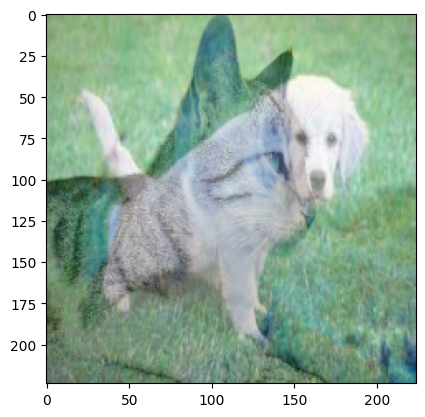

In [ ]:
# Example of Mix_up augmentation
import cv2
IM_SIZE = 224
image_1 = cv2.resize(cv2.imread('/content/pics/cat_cat_face_cats_eyes_240527.jpg'), (IM_SIZE, IM_SIZE))
image_2 = cv2.resize(cv2.imread('/content/pics/images.jpeg'), (IM_SIZE, IM_SIZE))


label_1 = 0
label_2 = 1

lamda = tfp.distributions.Beta(0.5, 0.4)
lamda = lamda.sample(1)[0]

image = lamda*image_1 + (1-lamda)*image_2
label = lamda*label_1 + (1-lamda)*label_2

print(image.shape, label)

plt.imshow(image/255) # normalizing and visualizing image


In [ ]:
def mixup(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda* tf.cast(label_1, dtype = tf.float32) + (1-lamda)* tf.cast(label_2, dtype = tf.float32)
  return image, label


In [ ]:
train_dataset_1 =  train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).map(resize_rescale) # the shape of bith datasets have to be same
train_dataset_2 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration= True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))
print(mixed_dataset)



<_ZipDataset element_spec=((TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)), (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)))>


## Cut-mix Augmentation

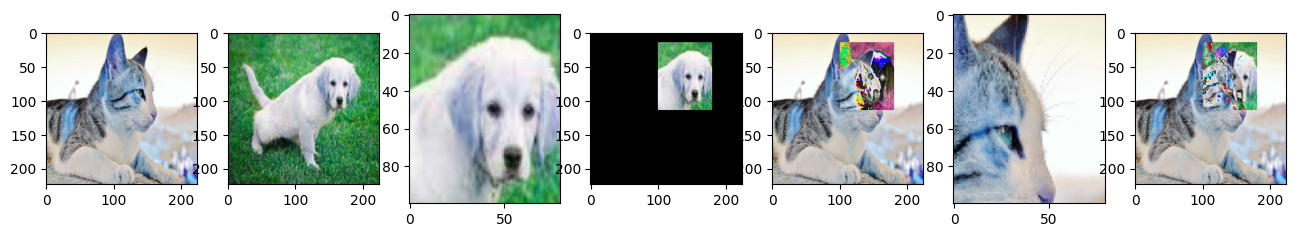

In [ ]:
# Set the desired image size
IM_SIZE = 224

# Increase plot size
plt.figure(figsize=(16, 8))

# Load and resize images
image_1 = cv2.resize(cv2.imread('/content/pics/cat_cat_face_cats_eyes_240527.jpg'), (IM_SIZE, IM_SIZE))
image_2 = cv2.resize(cv2.imread('/content/pics/images.jpeg'), (IM_SIZE, IM_SIZE))

# Display image_1 and image_2
plt.subplot(1, 7, 1)
plt.imshow(image_1)

plt.subplot(1, 7, 2)
plt.imshow(image_2)

# Crop and pad image_2
cropped_dog = tf.image.crop_to_bounding_box(image_2, offset_height=25, offset_width=110, target_height=100, target_width=80)
padded_dog = tf.image.pad_to_bounding_box(cropped_dog, offset_height=15, offset_width=100, target_height=IM_SIZE, target_width=IM_SIZE)

# Display cropped_dog and padded_dog
plt.subplot(1, 7, 3)
plt.imshow(cropped_dog)

plt.subplot(1, 7, 4)
plt.imshow(padded_dog)

# Perform arithmetic operations
plt.subplot(1, 7, 5)
result_image = image_1 - padded_dog
plt.imshow(result_image)

# Crop and pad image_1
cropped_cat = tf.image.crop_to_bounding_box(image_1, offset_height=25, offset_width=110, target_height=100, target_width=80)
padded_cat = tf.image.pad_to_bounding_box(cropped_cat, offset_height=15, offset_width=100, target_height=IM_SIZE, target_width=IM_SIZE)

# Display cropped_cat and padded_cat
plt.subplot(1, 7, 6)
plt.imshow(cropped_cat)

# Subtract, add, and display final result
plt.subplot(1, 7, 7)
final_image = image_1 - padded_cat + padded_dog
plt.imshow(final_image)

plt.show()

# in plt.subplot(1, is the number of rows, 7 is the number of plots(how many images we can plot(,
# 1, 2, 3, 4, 5 , 6, 7 is the image number or the plot number)


## Cutmix func

In [ ]:
# This snippet is generally used to pick random height and width of the given samples
def box(lamda):
  # lamda = tfp.distributions.Beta(0.2, 0.2) # generates random values based on probabilites and proportions
  # lamda = lamda.sample(1)[0]

  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w // 2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h // 2, 0, IM_SIZE) # this method_makes sure that the value stays only between 0, IM_SIZE not negative

  x_b_r = tf.clip_by_value(r_x + r_w // 2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h // 2, 0, IM_SIZE) # x_b_r is x bottom right and clip is to make the sure value is always inside the image bounds

  r_w = x_b_r - r_x
  if (r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if (r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w



In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2, 0.2) # generates random values based on probabilites and proportions
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda) # calling the function that creats random box in the image

  crop_1 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_2 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image_1 - pad_2 + pad_1

  # for label
  lamda = tf.cast(1 - (r_w * r_h) / (IM_SIZE * IM_SIZE) , dtype= tf.float32)
  label = lamda* tf.cast(label_1, dtype = tf.float32) + (1-lamda)* tf.cast(label_2, dtype = tf.float32)

  return image, label

tf.Tensor(
[9.9998009e-01 9.9902344e-01 0.0000000e+00 4.2171538e-02 4.2171538e-02
 1.7935038e-04 0.0000000e+00 0.0000000e+00 2.4555564e-01 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 9.9998009e-01 1.0000000e+00
 0.0000000e+00 0.0000000e+00 8.8789463e-01 7.6321352e-01 0.0000000e+00
 0.0000000e+00 1.0000000e+00 1.7935038e-04 0.0000000e+00 1.0000000e+00
 1.9907951e-05 1.7237324e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 0.0000000e+00 7.5444436e-01], shape=(32,), dtype=float32)


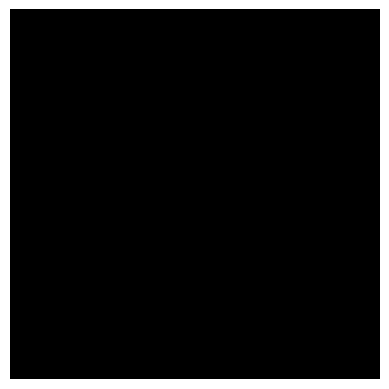

In [ ]:
# Visaualizing cutmix with train_dataset
original_image, label = next(iter(train_dataset))
plt.imshow(original_image[0])
print(label)
plt.axis('off')
plt.show()


<hr>

## Albumentations

In [26]:
transforms = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),

    A.OneOf([A.HorizontalFlip(),
             A.VerticalFlip()], p = 0.3),

    A.RandomRotate90(),
    A.RandomGridShuffle(),
    A.RandomBrightnessContrast(brightness_limit= 0.2,
                               contrast_limit= 0.2,
                               brightness_by_max= True,
                               always_apply=False, p=0.5),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
    A.Cutout(num_holes=10, max_h_size=8, max_w_size=8, fill_value=0, always_apply= False, p=0.7) # probability is p
])

In [27]:
def aug_albument(image):
  data = {'image': image}
  image = transforms(**data)
  image = image['image']
  image = tf.cast(image/255.0, tf.float32) # normalizing data

  return image

In [28]:
def process_data(image, label):
  aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32) # Tout means Tensor_type
  # tf.numpy_function basically converts python func above(aug_albument) to numpy to be processed in graph mode
  return aug_img, label

In [29]:
BATCH_SIZE = 32
train_dataset = (train_dataset
.shuffle(buffer_size = 1024, reshuffle_each_iteration= True)
.map(process_data)
# .map(resize_rescale)
.batch(BATCH_SIZE)
.prefetch(tf.data.AUTOTUNE))

In [30]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

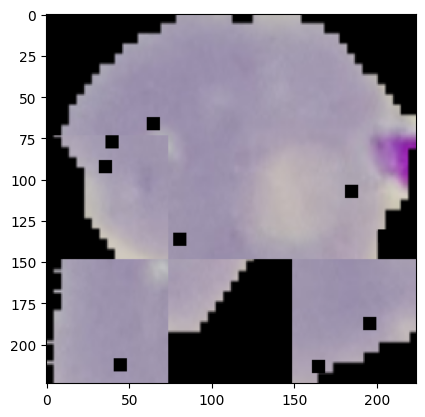

In [31]:
im, _ = next(iter(train_dataset)) # generally used when not taking the next data
plt.imshow(im[0])

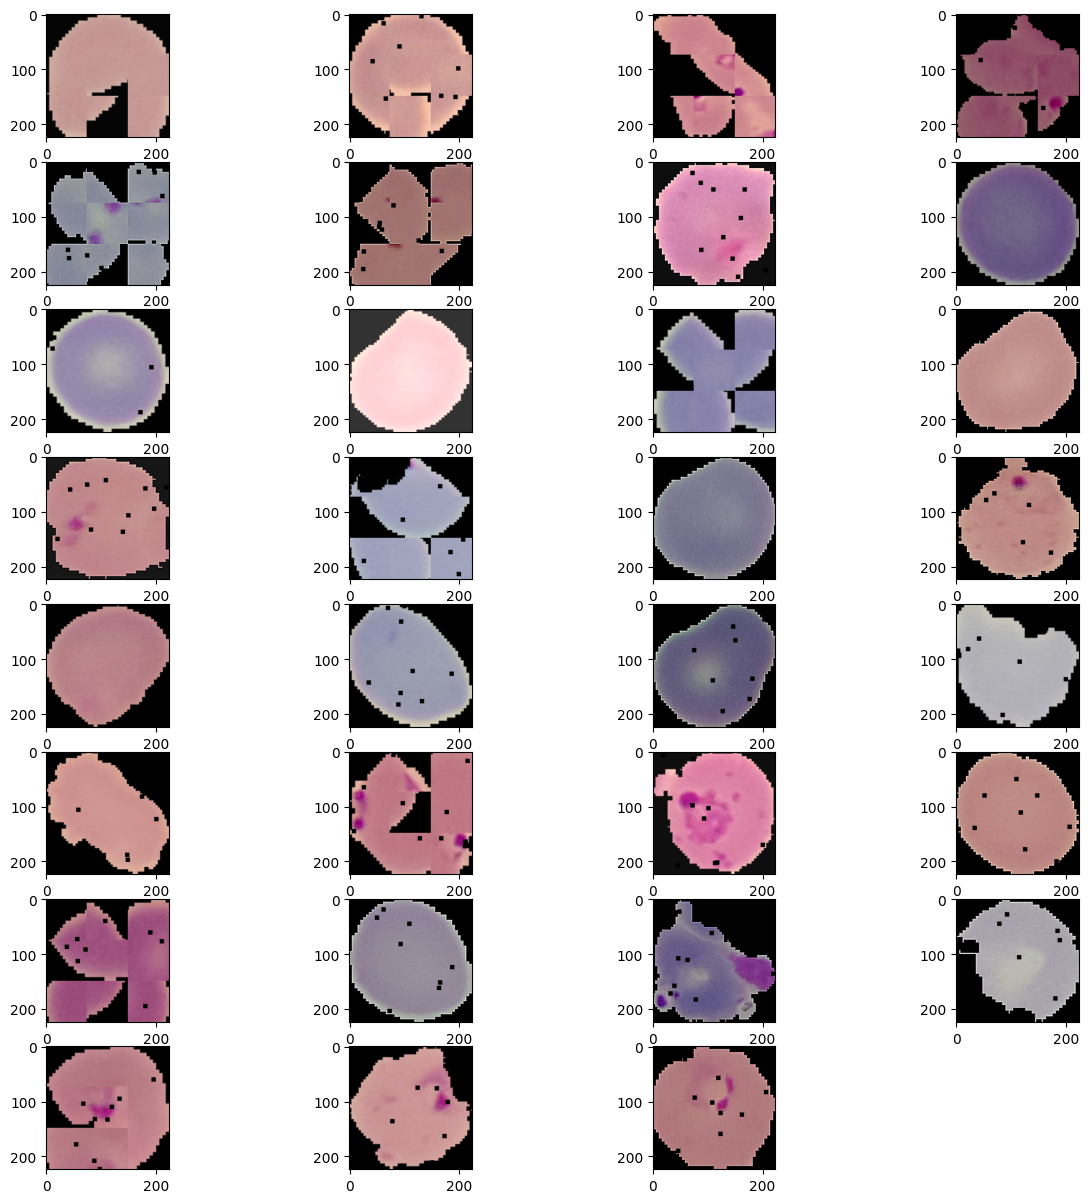

In [32]:
plt.figure(figsize=(15, 15))

for i in range(1, 32):
  plt.subplot(8, 4, i)
  plt.imshow(im[i])

## Dataset_augment mapping

In [ ]:
train_dataset = train_dataset.map(augment)
val_dataset = val_dataset.map(augment)
test_dataset = test_dataset.map(augment)
# no need if already declared in model

In [ ]:
for image, label in train_dataset.take(1):
  print(image)
  print(label)

##Batching

In [ ]:
BATCH_SIZE = 32
train_dataset = (mixed_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration= True)
# .map(augment_layer)
# .map(mixup)
.map(cutmix)
.map(resize_rescale)
.batch(BATCH_SIZE)
.prefetch(tf.data.AUTOTUNE))

TypeError: ignored

In [ ]:

BATCH_SIZE = 32
val_dataset = (val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration= True)
.map(resize_rescale)
.batch(BATCH_SIZE)
.prefetch(tf.data.AUTOTUNE)) # not using augment because we are predicting for original not augmented

In [ ]:

BATCH_SIZE = 32
test_dataset = (test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration= True)
.map(resize_rescale)
.batch(BATCH_SIZE)
.prefetch(tf.data.AUTOTUNE)) # not using augment because we are predicting for original not augmented

## <h2>Model Creation</h2>

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)), # can be None because you already have resize and rescale layers

    # resize_rescale_layers,
    augment_layers, # makes it easier to handle and not resize and rescale again and again

    tf.keras.layers.Conv2D(filters = 6, kernel_size = 3, strides=(1, 1), padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size= 2, strides = 2),

    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides=(1, 1), padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size= 2, strides = 2),

    Flatten(),

    Dense(100, activation = 'relu'),
    BatchNormalization(),

    Dense(10, activation = 'relu'),
    BatchNormalization(),

    Dense(1, activation = 'sigmoid'),


])
model.summary()
# using lenet model


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, None, None, 3)     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Batc  (None, 109, 109, 16)    

In [ ]:

model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy',
              run_eagerly = True) #graph mode on normal runtime # provides_much_clear_error_messages, if error is there then set it to false for faster compilation # gets accuracy of model
              # the normal way is called graph mode which is way faster



#<h1><b>Training and Optimisation</b></h1>

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = 5, verbose = 1)

Epoch 1/5
689/689 [==============================] - 150s 212ms/step - loss: 0.6420 - accuracy: 0.3407 - val_loss: 7390.6582 - val_accuracy: 0.5053
Epoch 2/5
689/689 [==============================] - 147s 213ms/step - loss: 0.6224 - accuracy: 0.3561 - val_loss: 211888.2031 - val_accuracy: 0.5049
Epoch 3/5
689/689 [==============================] - 148s 215ms/step - loss: 0.6107 - accuracy: 0.3639 - val_loss: 115931.3203 - val_accuracy: 0.5053
Epoch 4/5
689/689 [==============================] - 149s 216ms/step - loss: 0.6200 - accuracy: 0.3539 - val_loss: 0.9049 - val_accuracy: 0.4929
Epoch 5/5
689/689 [==============================] - 148s 214ms/step - loss: 0.6157 - accuracy: 0.3647 - val_loss: 5745.3066 - val_accuracy: 0.5114


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

#<h1><b>Model Evaluation and Testing</b></h1>

In [ ]:

# test1_dataset = test_dataset.take(1)
# test1_dataset

In [ ]:
test_dataset

In [ ]:
model.evaluate(test_dataset.take(1))

#<h1><b>Prediction</b></h1>

In [ ]:
def parasite_or_not(x):
  if (x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(100)):

  ax = plt.subplot(10, 10, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
  ax.axis('off')

# Data Augmentation

In [ ]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)


In [ ]:
original_image, label = next(iter(train_dataset))

In [ ]:
visualize(original_image, augmented_image)

# Running Inference

In [ ]:
import cv2

In [ ]:
image = cv2.imread('cell.jpg')
print(image.shape)
image = tf.expand(image, axis=0) # the dimension will be added in the first place where the batch size is
print(image.shape)

model.predict(image)